### Bruno Curzi-Laliberté, Thomas Rochefort-Beaudoin, Antoine Martin & Lucas Aubrun
### This is NOT the infogan file

In [1]:
# GAN inspired from :
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [2]:
# for Keras
import tensorflow

In [3]:
# for splitting keras Dataset, scikit learn has an easy way: sklearn.model_selection.train_test_split(...)
import sklearn.model_selection

In [4]:
# For creating tensors easily, also for random tensors with np.random
import numpy as np

In [5]:
# For displaying graphs, MNIST images & GAN images
import matplotlib.pyplot as plt

In [6]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tensorflow.compat.v1.Session(config=config)

In [7]:
# https://stackoverflow.com/a/59568642/10945691
import subprocess as sp
import os

def get_gpu_memory():
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(COMMAND.split()).decode('ascii').split('\n')[1:-1]
    memory_free_values = [int(x.split()[0]) for x in memory_free_info]
    return memory_free_values

# After building 1 model from Keras, this value will drop by 4-5GB, not sure why Keras allocates so much
get_gpu_memory()

[4208]

In [8]:
seed = 8225
batch = 256
half = batch//2
nsub = 54000 // batch

In [9]:
# MNIST
(kerasTrainX, kerasTrainY), (kerasTestX, kerasTestY) = tensorflow.keras.datasets.mnist.load_data(path="mnist.npz")
kerasTrainX, kerasValidX, kerasTrainY, kerasValidY = sklearn.model_selection.train_test_split(kerasTrainX, kerasTrainY, test_size=0.1, shuffle=True, random_state=seed)

In [10]:
imsize = 28, 28, 1

In [11]:
# Won't work if we don't scale down the values to [0, 1[ and add a depth dimension

kerasTrainX = kerasTrainX.reshape(54000, *imsize) / 256
kerasValidX = kerasValidX.reshape( 6000, *imsize) / 256
kerasTestX  = kerasTestX .reshape(10000, *imsize) / 256

In [12]:
def strideForDesiredOutputShapeConvT(insize, outsize):
    if outsize % insize != 0:
        raise Exception()
    return outsize // insize

In [13]:
def Generator(latentDimension, first_layer_dim, filters, kernels, strides):
    generator = tensorflow.keras.models.Sequential()
    generator.add(tensorflow.keras.layers.Dense(
        filters[0] * first_layer_dim ** 2,
        input_dim=latentDimension)
    )
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tensorflow.keras.layers.Reshape((first_layer_dim, first_layer_dim, filters[0])))
    for filters, kernel, stride in zip(filters, kernels, strides):
        generator.add(
            tensorflow.keras.layers.Conv2DTranspose(
                filters,
                kernel_size = (kernel, kernel),
                strides = stride,
                padding = 'same',
            )
        )
        generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tensorflow.keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return generator

In [14]:
def outSizeOfConv(size, kernel, stride, padding = 0):
    return (size - kernel + 2 * padding) / stride + 1

In [15]:
def calculateKernelsAndStridesForDesiredOutputShapeConv(insize, outsize, maxpadding = 0, verbose = False):
    if verbose:
        print(f'insize = {insize}, outsize = {outsize}')
    possibilities = []
    for padding in range(maxpadding + 1):
        for kernel in range(1, insize // 2 + 2):
            for stride in range(1, kernel + 1):
                if outSizeOfConv(insize, kernel, stride, padding) == outsize:
                    pos = (kernel, stride, padding)
                    if verbose:
                        print(f'kernel = {kernel}, stride = {stride}, padding = {padding}')
                    possibilities += [pos]
    return possibilities

In [16]:
def Discriminator(filters, kernels, strides):
    discriminator = tensorflow.keras.models.Sequential()
    for filters, kernel, stride in zip(filters, kernels, strides):
        stride = kernel - 1
        discriminator.add(
            tensorflow.keras.layers.Conv2D(
                filters,
                kernel_size = kernel,
                strides = stride,
                padding = 'same',
            )
        )
        discriminator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
        discriminator.add(tensorflow.keras.layers.Dropout(0.4))
    discriminator.add(tensorflow.keras.layers.Flatten())
    discriminator.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
    discriminator.compile(
        loss = 'binary_crossentropy',
        optimizer= tensorflow.keras.optimizers.Adam(lr=1e-4, beta_1=0.5), # 0.5 is interesting,
        metrics = ['accuracy'],
    )
    return discriminator

In [17]:
def GAN(G, D):
    D.trainable = False
    gan = tensorflow.keras.models.Sequential([G, D])
    gan.compile(
        loss = 'binary_crossentropy',
        optimizer = tensorflow.keras.optimizers.Adam(lr=1e-4, beta_1=0.5) # 0.5 is interesting
    )
    return gan

In [18]:
def train(
    g, d, gan,
    latent_dim,
    epochs,
    epochbegincallback    = None,
    epochendcallback      = None,
    subepochbegincallback = None,
    subepochendcallback   = None,
):
    for epoch in range(epochs):
        if epochbegincallback: epochbegincallback(epoch + 1)
        for subepoch in range(nsub):
            if subepochbegincallback: subepochbegincallback(epoch + 1, subepoch + 1)
            GX, GY = g.predict(np.random.randn(latent_dim * half).reshape(half, latent_dim)), np.zeros((half, 1))
            DX, DY =  kerasTrainX[np.random.randint(0, kerasTrainX.shape[0], half)], np.ones((half, 1))
            d.train_on_batch(np.vstack((GX, DX)), np.vstack((GY, DY)))
            X_gan = np.random.randn(latent_dim, batch).reshape(batch, latent_dim)
            y_gan = np.ones((batch, 1))
            gan.train_on_batch(X_gan, y_gan)
            if subepochendcallback: subepochendcallback(epoch + 1, subepoch + 1)
        if epochendcallback: epochendcallback(epoch + 1)

In [19]:
def plotSome():
    S = 8
    X = generator.predict(np.random.randn(latentDimension * 2 * S * S).reshape((2 * S * S, latentDimension)))
    plt.subplots(figsize=(2*S, S))
    for i in range(2 * S * S):
        plt.subplot(S, 2 * S, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    plt.show()

epoch 1: 210 / 210
epoch 2: 210 / 210
epoch 3: 210 / 210
epoch 4: 210 / 210
epoch 5: 210 / 210
epoch 6: 210 / 210
epoch 7: 210 / 210
epoch 8: 210 / 210
epoch 9: 210 / 210
epoch 10: 210 / 210


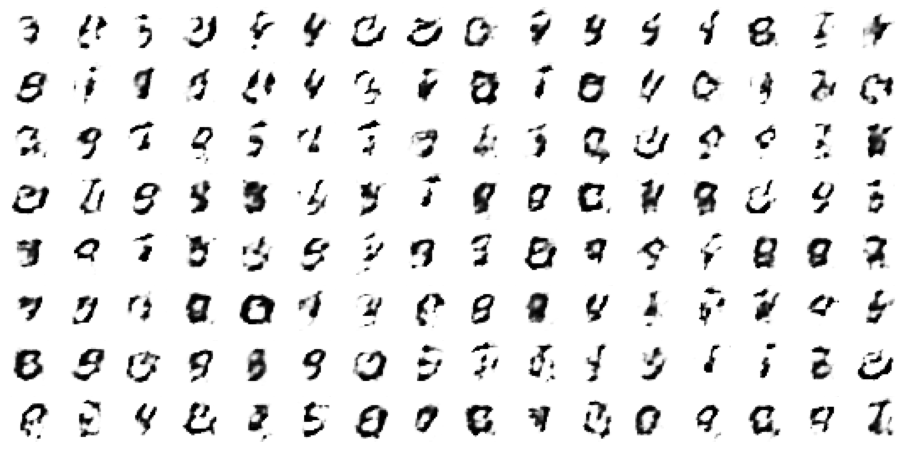

In [20]:
filters = [128, 128]
kernels = [2, 2]
strides = [2, 2]
latentDimension = 10
first_layer_dim = 7
generator = Generator(latentDimension, first_layer_dim, filters, kernels, strides)
filters = [64] * 2
kernels = [3] * 2
strides = [2] * 2
discriminator = Discriminator(filters, kernels, strides)
gan = GAN(generator, discriminator)
train(
    generator,
    discriminator,
    gan,
    latentDimension,
    epochs = 10,
    subepochbegincallback = lambda ep, subep: print(f'\repoch {ep}: {subep} / {nsub}', end=''),
    epochendcallback = lambda ep: print(),
)
plotSome()

epoch 1: 210 / 210
epoch 2: 210 / 210
epoch 3: 210 / 210
epoch 4: 210 / 210
epoch 5: 210 / 210
epoch 6: 210 / 210
epoch 7: 210 / 210
epoch 8: 210 / 210
epoch 9: 210 / 210
epoch 10: 210 / 210


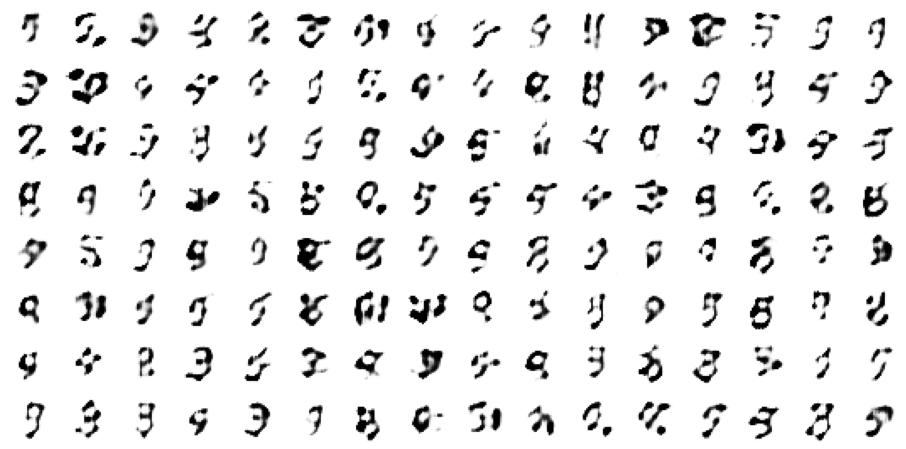

In [21]:
filters = [128, 128]
kernels = [5, 5]
strides = [2, 2]
latentDimension = 10
first_layer_dim = 7
generator = Generator(latentDimension, first_layer_dim, filters, kernels, strides)
filters = [64] * 2
kernels = [3] * 2
strides = [2] * 2
discriminator = Discriminator(filters, kernels, strides)
gan = GAN(generator, discriminator)
train(
    generator,
    discriminator,
    gan,
    latentDimension,
    epochs = 10,
    subepochbegincallback = lambda ep, subep: print(f'\repoch {ep}: {subep} / {nsub}', end=''),
    epochendcallback = lambda ep: print(),
)
plotSome()

In [22]:
calculateKernelsAndStridesForDesiredOutputShapeConv(28, 7, verbose = True);

insize = 28, outsize = 7
kernel = 4, stride = 4, padding = 0
kernel = 10, stride = 3, padding = 0


In [23]:
calculateKernelsAndStridesForDesiredOutputShapeConv(32, 28, verbose = True);

insize = 32, outsize = 28
kernel = 5, stride = 1, padding = 0
